### Tổng quan về mô hình SIRD
- SIRD (Suspectible - Infectious - Recovered - Death) là một trong những mô hình toán học để mô tả dịch bệnh COVID-19 hiện nay.
- Mô hình SIRD là một hệ phương trình vi phân sau:
  - $\dfrac{dS}{dt}= \dfrac{-\beta}{N}IS$
  - $\dfrac{dI}{dt}= \dfrac{\beta}{N}IS -\gamma I - \alpha I$
  - $\dfrac{dR}{dt}= \gamma I $
  - $\dfrac{dD}{dt}= \alpha I$  
  trong đó tại mỗi thời điểm $t \ge t_0 \ge 0$ với $t_0$ là thời điểm đầu ghi nhận.  
  - $S(t)$: Số người có nguy cơ mắc bệnh.  
  - $I(t)$: Số người nhiễm bệnh.
  - $R(t)$: Số người phục hồi sau bệnh.
  - $D(t)$: Số người chết.
  - $\beta$: Tỷ lệ tiếp xúc mỗi người trong nhóm $S(t)$ với người trong nhóm $I(t)$. (hệ số lây nhiễm)
  - $\gamma$: Tỷ lệ phục hồi sau bệnh. (hệ số phục hồi)
  - $\alpha$: Tỷ lệ tử vong khi nhiễm bệnh. (hệ số tử vong)
  - $N(t)$: Tổng số người trong cộng đồng đang xét.  
  $N(t)= S(t) + I(t) + R(t) +D(t)
$

### Import thư viện


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import scipy
import datetime
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU
from tensorflow.keras import optimizers
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Chuẩn bị dữ liệu
- Dữ liệu được tải trực tiếp từ link Github: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series.
- Dữ liệu được cập nhật hàng ngày của mỗi quốc gia trên toàn cầu.
- Gồm 3 file: 
    - time_series_covid19_confirmed_global.csv: Số ca xác nhận.
    - time_series_covid19_deaths_global.csv: Số ca chết.
    - time_series_covid19_recovered_global.csv: Số ca hồi phục


In [2]:
# Các đường link dẫn đến 3 file trên
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [3]:
# Cộng tổng các trường hợp "nhiễm", "nhiễm chết", "hồi phục" ("infected", "death", "recovered") trên một số quốc gia (chọn trước).
# Biểu diễn ở dạng Data Frame
def df_process_sum(url, label, country_list):
  df= pd.read_csv(url)
  df.set_index("Country/Region", inplace=True)
  df.index.name="Date"
  df=df.loc[country_list]
  df.drop(df.columns[:3], axis=1, inplace=True)
  df=df.T
  df[label]=df.sum(axis=1, skipna=True, numeric_only=True)
  df=df[[label]]
  return df


- Đầu tiên ta thử nghiệm trên một số quốc gia (country_list) ở khu vực châu Á như: Việt Nam, Thái Lan, Malaysia, Nhật Bản, South Korea, Indonesia, Singapore, Philippines, Ấn Độ, Iran.
- Phần sau sẽ thử nghiệm nhiều quốc gia trên thế giới.


In [4]:
#Danh sách các quốc gia được nêu ở trên
country_list_asia=["Vietnam", "Thailand", "Malaysia", "Japan", "Korea, South", "Indonesia", "Singapore", "Philippines", "India", "Iran"]

print("Number of country: ", len(country_list_asia))

#Dân số từng quốc gia
population_each_country_asia={
    "N_Vietnam": 97_090_803, "N_Thailan": 69_751_086, "N_Malaysia": 32_247_753, "N_Japan": 126_444_437, "N_Korea": 51_256_910, 
    "N_Indonesia":272_702_678, "N_Singapore" : 5_837_355, "N_Philippines": 109_164_767, "N_India": 1_376_159_354, "N_Iran": 83_686_406
}

print(len(population_each_country_asia))

#Tổng dân số của các quốc gia trên
N_asia=sum(population_each_country_asia.values())
print("Population: ", N_asia)


Number of country:  10
10
Population:  2224341549


5 dòng dữ liệu đầu tiên
Date     recovered  death  infected
1/22/20          0      0         5
1/23/20          0      0         9
1/24/20          0      0        14
1/25/20          0      0        19
1/26/20          3      0        22
5 dòng dữ liệu cuối
Date     recovered  death  infected
7/27/20    1383675  57610    623552
7/28/20    1425889  58698    639329
7/29/20    1462658  59745    660282
7/30/20    1503452  60824    677857
7/31/20    1547436  61892    700345


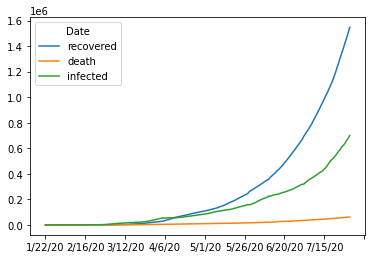

In [5]:
recovered_df = df_process_sum(recovered_url, "recovered", country_list_asia) #Tổng số ca hồi phục của các quốc gia trên.
death_df = df_process_sum(death_url, "death", country_list_asia) #Tổng số ca chết của các quốc gia trên
confirmed_df = df_process_sum(confirmed_url, "confirmed", country_list_asia) #Tổng số ca xác nhận của các quốc gia trên

#Gộp 3 cột
covid_df = recovered_df.merge(confirmed_df, left_index=True, right_index=True)
covid_df= covid_df.merge(death_df, left_index=True, right_index=True)

#Ta có Ca(infected)= Ca(confirmed)- Ca(recovered) - Ca(death)
covid_df["infected"] = covid_df["confirmed"]- covid_df["recovered"] - covid_df["death"]

#Bỏ cột confirmed
covid_df.drop(["confirmed"], axis=1, inplace=True)

#In thử bảng dữ liệu đã xử lý
print("5 dòng dữ liệu đầu tiên")
print(covid_df.head())
print("5 dòng dữ liệu cuối")
print(covid_df.tail())

#Vẽ đồ thị 
covid_df.plot()




Date,recovered,death,infected,suscepted
7/27/20,1383675,57610,623552,2222276712
7/28/20,1425889,58698,639329,2222217633
7/29/20,1462658,59745,660282,2222158864
7/30/20,1503452,60824,677857,2222099416
7/31/20,1547436,61892,700345,2222031876


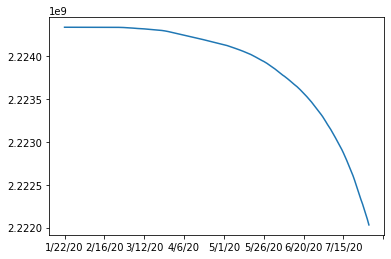

In [6]:
# Tính số người có nguy cơ mắc bệnh và gộp vào bảng dữ liệu
covid_df['suscepted'] = N_asia - covid_df['recovered'] - covid_df['infected']-covid_df["death"]
covid_df["suscepted"].plot()
covid_df.tail()

- Bây giờ để tìm số người nhiễm bệnh $I(t)$, số người đã phục hồi $R(t)$, số người chết $D(t)$, số người không nhiễm bệnh và có nguy cơ nhiễm $S(t)$ tính tại thời điểm $t \ge t_0$ ta sử dụng thuật toán Euler với tham số đầu vào bao gồm $t, \beta, \gamma, \alpha$ và $I(t_0), R(t_0), D(t_0), S(t_0)$.
- Phương pháp Euler là một phương pháp thường được sử dụng trong việc giải các hệ phương trình vi phân thông thường.  
- Giả sử ta có phương trình vi phân bậc nhất  
$ y'= f(t, y(t))$  
Khi đó ý tưởng của phương pháp Euler là xấp xỉ nghiệm $y$ bằng dãy $\{y_n\}$ sao cho $ y_{n+1}:=y_n +f(t_n, y_n)\Delta t$ với $\Delta t$ là bước xấp xỉ đủ nhỏ.
- Đầu tiên từ dữ liệu ta sẽ đi tìm các tham số $\beta, \gamma, \alpha $ dựa trên ý tưởng của thuật toán này.

In [7]:
# Từ dữ liệu về covid đã có, ta sẽ ước lượng tìm các tham số trong hệ phương trình vi phân: beta, gamma, alpha
def find_parameters(df, N_population):
  # Số lượng mẫu dữ liệu
  size=df.shape[0]
  #Khai báo mảng các tham số beta, gamma, alpha
  betas=np.zeros(size)
  gammas=np.zeros(size)
  alphas=np.zeros(size)
  for i in range(size-1):
    betas[i] = -(covid_df["suscepted"][i+1] - covid_df["suscepted"][i]) * N_population/ (covid_df["infected"][i] * covid_df["suscepted"][i])
    gammas[i] = (covid_df["recovered"][i+1] - covid_df["recovered"][i]) / covid_df["infected"][i]
    alphas[i]= (covid_df["death"][i+1] - covid_df["death"][i]) / covid_df["infected"][i]
  
  gammas[-1] = gammas[:-1].mean()
  betas[-1] = betas[:-1].mean()
  alphas[-1]= alphas[:-1].mean()
  print("beta: ", betas[-1])
  print("gamma: ", gammas[-1])
  print("alpha: ", alphas[-1])
  df["beta"] = betas
  df["gamma"] = gammas
  df["alpha"]=alphas
  return df, betas, gammas, alphas


In [8]:
covid_df, betas, gammas, alphas = find_parameters(covid_df, N_asia)
beta= betas[-1]
gamma= gammas[-1]
alpha= alphas[-1]
covid_df.head()

beta:  0.1171495319638256
gamma:  0.04463037515109282
alpha:  0.0030024018578381196


Date,recovered,death,infected,suscepted,beta,gamma,alpha
1/22/20,0,0,5,2224341544,0.800000,0.000000,0.0
1/23/20,0,0,9,2224341540,0.555556,0.000000,0.0
1/24/20,0,0,14,2224341535,0.357143,0.000000,0.0
1/25/20,0,0,19,2224341530,0.315789,0.157895,0.0
1/26/20,3,0,22,2224341524,0.090909,0.000000,0.0


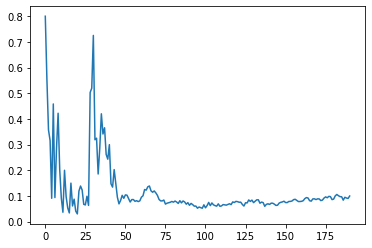

In [9]:
plt.plot(range(betas.size-1), betas[:-1])

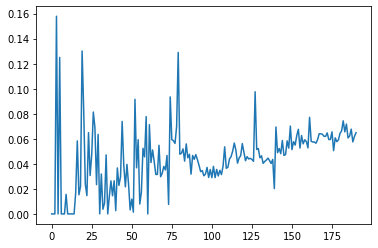

In [10]:
plt.plot(range(gammas.size-1), gammas[:-1])

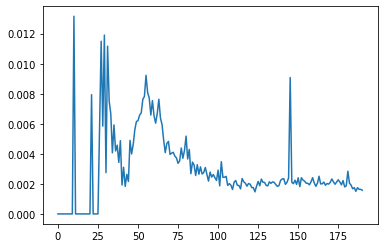

In [11]:
plt.plot(range(alphas.size-1), alphas[:-1])

In [12]:
# Tìm S, I, R, D dựa vào thuật toán Euler
def SIRD_Model(beta, gamma, alpha, N, S, I, R, D, iteration, start, end=None):
    times = pd.date_range(start, periods=iteration)

    for t in range (iteration-1):
        S[t+1] = S[t] - beta*S[t]*I[t]/N
        I[t+1] = I[t] + beta*S[t]*I[t]/N - (gamma+alpha)*I[t]
        R[t+1] = R[t] + gamma*I[t]
        D[t+1]= D[t]+ alpha*I[t]
    
    data = {"suscepted": S, "infected": I, "recovered": R, "death": D}

    df = pd.DataFrame(data, columns=["suscepted", "infected", "recovered", "death"])
    df["Date"] = pd.to_datetime(times)
    df.set_index("Date", inplace=True)
    print(df.head())
    print(df.tail())

    plt.figure(figsize=(22, 20))
    df[["suscepted","infected", "recovered", "death"]].plot()
    plt.title("SIRD Model")
    plt.legend(fontsize=12)

1547436.0 700345.0 2222031876.0 61892.0 0.1171495319638256 0.04463037515109282 0.0030024018578381196
               suscepted       infected     recovered         death
Date                                                               
2020-07-30  2.222032e+09  700345.000000  1.547436e+06  61892.000000
2020-07-31  2.221950e+09  748945.519200  1.578693e+06  63994.717129
2020-08-01  2.221862e+09  800915.443949  1.612118e+06  66243.352547
2020-08-02  2.221769e+09  856487.906076  1.647864e+06  68648.022564
2020-08-03  2.221668e+09  915912.101302  1.686089e+06  71219.543445
               suscepted      infected     recovered         death
Date                                                              
2021-08-29  2.445076e+08  88452.853856  1.854997e+09  1.247483e+08
2021-08-30  2.445065e+08  85378.650288  1.855001e+09  1.247486e+08
2021-08-31  2.445054e+08  82411.286399  1.855005e+09  1.247488e+08
2021-09-01  2.445043e+08  79547.049475  1.855009e+09  1.247491e+08
2021-09-02  2.445033e

<Figure size 1584x1440 with 0 Axes>

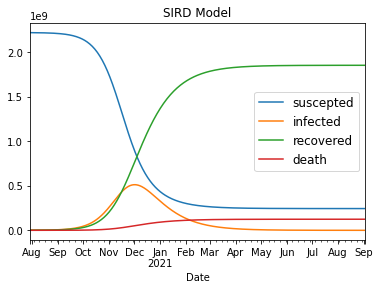

In [13]:
iteration = 400
start = "30-07-2020"

S = np.zeros(iteration)
I = np.zeros(iteration)
R = np.zeros(iteration)
D= np.zeros(iteration)

R[0], D[0], I[0], S[0], beta, gamma, alpha = covid_df.iloc[-1]

beta = betas[-1]
gamma = gammas[-1]
alpha =alphas[-1]
print(R[0], I[0], S[0], D[0], beta, gamma, alpha)

SIRD_Model(beta, gamma, alpha, N_asia, S, I, R, D, iteration, start)


- Ta cũng có thể sử dụng hàm odeint trong thư viện scipy để giải hệ phương trình vi phân này.

In [14]:
def system_differential_equations(y, t, N, beta, gamma, alpha):
    S, I, R, D = y
    dSdt = -beta * S * I/N
    dIdt = beta * S * I/N - (gamma+alpha) * I
    dRdt = gamma * I
    dDdt = alpha*I
    return dSdt, dIdt, dRdt, dDdt

               suscepted       infected     recovered         death
Date                                                               
2020-07-30  2.222032e+09  700345.000000  1.547436e+06  61892.000000
2020-07-31  2.221947e+09  750669.869531  1.579803e+06  64069.391826
2020-08-01  2.221856e+09  804607.224839  1.614495e+06  66403.239776
2020-08-02  2.221759e+09  862415.828337  1.651680e+06  68904.774013
2020-08-03  2.221654e+09  924372.893802  1.691537e+06  71586.028947


<Figure size 864x720 with 0 Axes>

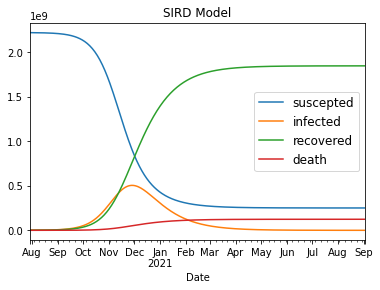

In [15]:
t = np.linspace(0, iteration-1, iteration) 
y0 = S[0], I[0], R[0], D[0]
sol = odeint(system_differential_equations, y0, t, args=(N_asia, beta, gamma, alpha))
S, I, R, D = sol.T

data = {"suscepted": S, "infected": I, "recovered": R, "death": D}

times = pd.date_range(start, periods=iteration)
df = pd.DataFrame(data, columns=["suscepted", "infected", "recovered", "death"])
df["Date"] = pd.to_datetime(times)
df.set_index("Date", inplace=True)
print(df.head())

plt.figure(figsize=(12, 10))
df[["suscepted", "infected", "recovered", "death"]].plot()
plt.title("SIRD Model")
plt.legend(fontsize=12)


### Thử nghiệm mô hình trên dữ liệu nhiều quốc gia trên thế giới (chọn top 50 các quốc gia có số ca nhiễm lớn nhất+ Việt Nam)

In [16]:
country_list_global = ["Singapore", "Thailand", "Japan", "Australia", "Italy", "Indonesia","Vietnam", "Korea, South", "China", "Malaysia","Germany",
                "France","Iran","Canada","Chile","India","Mexico","Turkey", "US", "Colombia", "Brazil", "Argentina", "Portugal", "United Kingdom",
                "Peru", "Spain", "Russia", "Belgium", "Netherlands", "South Africa", "Sweden", "Saudi Arabia", "Pakistan", "Israel", "Poland",
                "Romania", "Philippines", "Bangladesh", "Qatar", "Egypt", "Iraq", "Kazakhstan", "Ecuador", "Ukraine", "Oman", "Belarus",
                "Bolivia", "Kuwait", "Dominican Republic", "Panama", "United Arab Emirates"]
print("Countries: ", len(country_list_global))

population_each_country_global={
"N_Singapore" : 5_837_355, "N_Thailan": 69_751_086, "N_Japan": 126_444_437, "N_Australia": 25_414_113, "N_Italy":60_486_441, "N_Indonesia":272_702_678,
"N_Vietnam": 97_090_803, "N_Korea": 51_256_910, "N_China": 1_437_767_915, "N_Malaysia": 32_247_753, "N_Germany": 83_709_051, "N_France":65_233_217,
"N_Iran": 83_686_406, "N_Canada": 37_648_579, "N_Chile": 19_069_370, "N_India": 1_376_159_354, "N_Mexico": 128_544_624, "N_Turkey": 84_081_383,
"N_US": 330_457_064, "N_Colombia": 50_727_450, "N_Brazil": 212_129_490, "N_Argentina": 45_077_268, "N_Portugal": 10_494_500, "N_UK": 66_775_711,
"N_Peru": 32_839_329, "N_Spain": 46_749_745, "N_Russia": 145_917_069, "N_Belgium": 11_575_489, "N_Netherlands": 17_124_295, "N_SA": 59_095_558,
"N_Sweden": 10_081_550, "N_SaudiArabia": 34_658_388, "N_Pakistan": 219_652_490, "Israel": 8_616_712, "N_Poland": 37_858_096, "N_Romania": 19_272_844, 
"N_Philippines": 109_164_767, "N_Bangladesh": 164_224_271, "N_Qatar": 2_867_063, "N_Egypt": 101_777_112, "N_Iraq": 39_959_936,
"N_Kazakhstan":  18_712_777, "N_Ecuador": 17565554, "N_Ukraine": 43_805_831, "N_Oman": 5_068_609, "N_Belarus": 9_450_186, "N_Bolivia": 11_627_105,
"N_Kuwait": 4_252_488, "N_Dominican":  10_847_910, "N_Panama": 4_295_096, "N_UAE": 9_856_379
}
print(len(population_each_country_global))
N_global=sum(population_each_country_global.values())
print("Population: ", N_global)

Countries:  51
51
Population:  5969709607


5 dòng dữ liệu đầu tiên
Date     recovered  death  infected
1/22/20         28     17       509
1/23/20         30     18       605
1/24/20         36     26       876
1/25/20         39     42      1349
1/26/20         52     56      2005
5 dòng dữ liệu cuối
Date     recovered   death  infected
7/27/20    8942084  628347   5938285
7/28/20    9104755  634452   6006306
7/29/20    9294209  640789   6083506
7/30/20    9467981  646525   6164694
7/31/20    9652349  652429   6243087


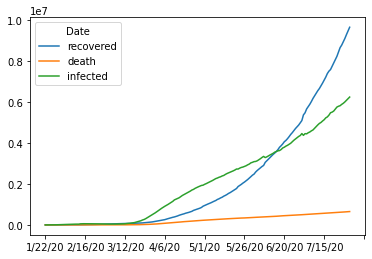

In [17]:
recovered_df = df_process_sum(recovered_url, "recovered", country_list_global) #Tổng số ca hồi phục của các quốc gia trên.
death_df = df_process_sum(death_url, "death", country_list_global) #Tổng số ca chết của các quốc gia trên
confirmed_df = df_process_sum(confirmed_url, "confirmed", country_list_global) #Tổng số ca xác nhận của các quốc gia trên

#Gộp 3 cột
covid_df = recovered_df.merge(confirmed_df, left_index=True, right_index=True)
covid_df= covid_df.merge(death_df, left_index=True, right_index=True)

#Ta có Ca(infected)= Ca(confirmed)- Ca(recovered) - Ca(death)
covid_df["infected"] = covid_df["confirmed"]- covid_df["recovered"] - covid_df["death"]

#Bỏ cột confirmed
covid_df.drop(["confirmed"], axis=1, inplace=True)

#In thử bảng dữ liệu đã xử lý
print("5 dòng dữ liệu đầu tiên")
print(covid_df.head())
print("5 dòng dữ liệu cuối")
print(covid_df.tail())

#Vẽ đồ thị 
covid_df.plot()


Date,recovered,death,infected,suscepted
7/27/20,8942084,628347,5938285,5954200891
7/28/20,9104755,634452,6006306,5953964094
7/29/20,9294209,640789,6083506,5953691103
7/30/20,9467981,646525,6164694,5953430407
7/31/20,9652349,652429,6243087,5953161742


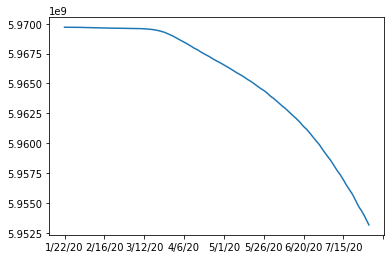

In [18]:
# Tính số người có nguy cơ mắc bệnh và gộp vào bảng dữ liệu
covid_df["suscepted"] = N_global - covid_df["recovered"] - covid_df["infected"]-covid_df["death"]
covid_df["suscepted"].plot()
covid_df.tail()

In [19]:
covid_df, betas, gammas, alphas = find_parameters(covid_df, N_global)
beta= betas[-1]
gamma= gammas[-1]
alpha= alphas[-1]
covid_df.head()

beta:  0.08402977791469467
gamma:  0.025497318995215592
alpha:  0.003451885673344997


Date,recovered,death,infected,suscepted,beta,gamma,alpha
1/22/20,28,17,509,5969709053,0.194499,0.003929,0.001965
1/23/20,30,18,605,5969708954,0.471074,0.009917,0.013223
1/24/20,36,26,876,5969708669,0.561644,0.003425,0.018265
1/25/20,39,42,1349,5969708177,0.506301,0.009637,0.010378
1/26/20,52,56,2005,5969707494,0.401995,0.004489,0.012968


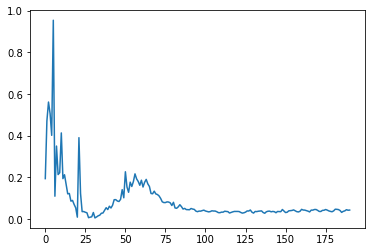

In [20]:
plt.plot(range(betas.size-1), betas[:-1])

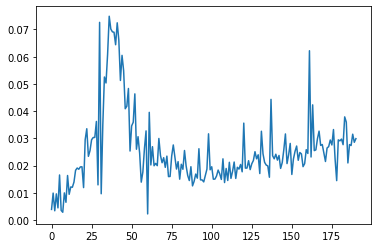

In [21]:
plt.plot(range(gammas.size-1), gammas[:-1] )

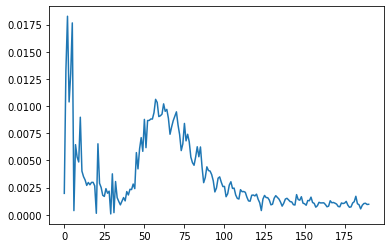

In [22]:
plt.plot(range(alphas.size-1), alphas[:-1])

9652349.0 6243087.0 5953161742.0 652429.0 0.08402977791469467 0.025497318995215592 0.003451885673344997
               suscepted      infected     recovered          death
Date                                                               
2020-07-30  5.953162e+09  6.243087e+06  9.652349e+06  652429.000000
2020-07-31  5.952639e+09  6.585506e+06  9.811531e+06  673979.422573
2020-08-01  5.952087e+09  6.946657e+06  9.979444e+06  696711.835074
2020-08-02  5.951505e+09  7.327559e+06  1.015656e+07  720690.899470
2020-08-03  5.950891e+09  7.729288e+06  1.034340e+07  745984.796253
               suscepted       infected     recovered         death
Date                                                               
2021-12-07  3.880688e+08  832409.523686  4.915932e+09  6.648759e+08
2021-12-08  3.880643e+08  812858.939163  4.915954e+09  6.648788e+08
2021-12-09  3.880599e+08  793767.482074  4.915974e+09  6.648816e+08
2021-12-10  3.880555e+08  775124.372651  4.915995e+09  6.648843e+08
2021-12-11  

<Figure size 1584x1440 with 0 Axes>

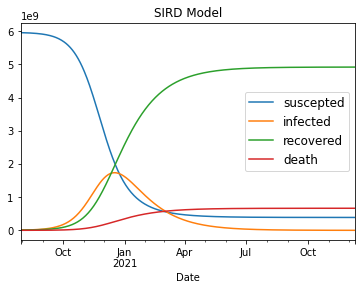

In [23]:
iteration = 500
start = "30-07-2020"

S = np.zeros(iteration)
I = np.zeros(iteration)
R = np.zeros(iteration)
D= np.zeros(iteration)

R[0], D[0], I[0], S[0], beta, gamma, alpha = covid_df.iloc[-1]

beta = betas[-1]
gamma = gammas[-1]
alpha =alphas[-1]
print(R[0], I[0], S[0], D[0], beta, gamma, alpha)

SIRD_Model(beta, gamma, alpha, N_global, S, I, R, D, iteration, start)

               suscepted      infected     recovered          death
Date                                                               
2020-07-30  5.953162e+09  6.243087e+06  9.652349e+06  652429.000000
2020-07-31  5.952624e+09  6.595045e+06  9.815977e+06  674581.341515
2020-08-01  5.952056e+09  6.966791e+06  9.988829e+06  697982.447830
2020-08-02  5.951456e+09  7.359431e+06  1.017142e+07  722702.514638
2020-08-03  5.950822e+09  7.774133e+06  1.036431e+07  748815.662984


<Figure size 864x720 with 0 Axes>

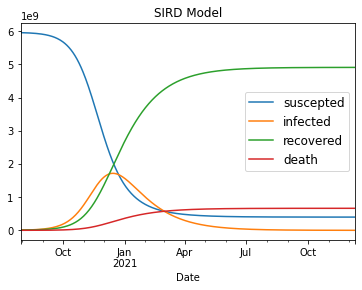

In [24]:
t = np.linspace(0, iteration-1, iteration) 
y0 = S[0], I[0], R[0], D[0]
sol = odeint(system_differential_equations, y0, t, args=(N_global, beta, gamma, alpha))
S, I, R, D = sol.T

data = {"suscepted": S, "infected": I, "recovered": R, "death": D}

times = pd.date_range(start, periods=iteration)
df = pd.DataFrame(data, columns=["suscepted", "infected", "recovered", "death"])
df["Date"] = pd.to_datetime(times)
df.set_index("Date", inplace=True)
print(df.head())

plt.figure(figsize=(12, 10))
df[["suscepted", "infected", "recovered", "death"]].plot()
plt.title("SIRD Model")
plt.legend(fontsize=12)


### Hướng tiếp cận dùng Học Máy (Machine Learning)
- Các mô hình học máy cũng được đưa vào dự đoán tình hình dịch bệnh COVID-19 trong các tháng vừa qua. 
- Ý tưởng: Khởi tạo SIR hoặc SIRD với các tham số ban đầu $\beta$ (hệ số lây nhiễm), $\gamma$ (hệ số phục hồi), $\alpha$ (hệ số tử vong nếu là SIRD) để tính ra $I, R, D$ tại thời điểm $t \ge t_0$. Sau đó dùng một Neural Network và dữ liệu về số ca nhiễm, ca tử vong và hồi phục đã công bố để ước tính lại các chỉ số $\beta, \gamma, \alpha$ tại mỗi thời điểm công bố dịch bệnh COVID-19.  
[![SIRD.png](https://i.postimg.cc/LXgfjXx2/SIRD.png)](https://postimg.cc/JDmGL1w2)  
Hình: Mô hình minh họa hướng tiếp cận dùng Học máy trong mô tả dịch bệnh COVID-19, được trích từ bài báo gốc.
- Chi tiết về cách xây dựng mô hình, hàm loss xem tại bài báo  
[First-principles machine learning modelling of
COVID-19](https://arxiv.org/pdf/2004.09478.pdf) 
- Ở đây để cài đặt minh họa em sẽ dùng mô hình SIR (cho kết quả tốt), mô hình SIRD đã thử nghiệm nhưng không tối ưu được (do hàm loss khá phức tạp) dẫn đến underfitting.  



In [25]:
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

Date,removed,infected
7/27/20,9570431,5938285
7/28/20,9739207,6006306
7/29/20,9934998,6083506
7/30/20,10114506,6164694
7/31/20,10304778,6243087


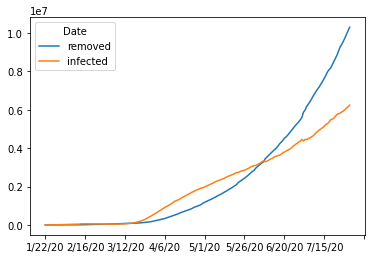

In [26]:
recovered_df = df_process_sum(recovered_url, "removed", country_list_global)
death_df = df_process_sum(death_url, "removed", country_list_global)
removed_df = recovered_df.add(death_df, fill_value=0)
confirmed_df = df_process_sum(confirmed_url, "confirmed", country_list_global)
covid_df = removed_df.merge(confirmed_df, left_index=True, right_index=True)
covid_df["infected"] = covid_df["confirmed"] - covid_df["removed"]
covid_df.drop(['confirmed'], axis=1, inplace=True)
covid_df.plot()
covid_df.tail()

Date      removed  infected   suscepted
7/27/20   9570431   5938285  5954200891
7/28/20   9739207   6006306  5953964094
7/29/20   9934998   6083506  5953691103
7/30/20  10114506   6164694  5953430407
7/31/20  10304778   6243087  5953161742


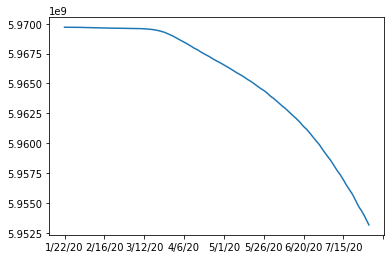

In [27]:
covid_df["suscepted"]=N_global -covid_df["removed"] - covid_df["infected"]
print(covid_df.tail())
covid_df["suscepted"].plot()

In [28]:
def SIR_Model(beta, gamma, S0, I0, R0, iteration):
  N=S0+I0+R0
  S=np.zeros(iteration)
  I=np.zeros(iteration)
  R=np.zeros(iteration)

  S[0], I[0], R[0] = S0, I0, R0
  for t in range(iteration-1):
    S[t+1]= S[t] - beta[t]*I[t]*S[t]/N
    I[t+1]= I[t] +beta[t]*I[t]*S[t]/N -gamma[t]*I[t]
    R[t+1]= R[t] +gamma[t]*I[t]
  
  return np.array([I, R])

def custom_loss(y_true, y_pred):
  loss = K.square(y_true-y_pred)
  loss = K.sum(loss, axis=1)
  return loss

def split_data(step, data):
  sizeX= data.shape[0]
  sizeY= data.shape[1]

  new_data=[]

  for i in range(sizeX-step):
    new_data.append(data[i: i+step])
  
  print(np.array(new_data).shape)
  
  final_data= np.array(new_data).reshape(sizeX-step, sizeY *step)
  return final_data


def load_data():
  train_test_split = covid_df.shape[0] - 1 
  train_data = np.array(covid_df[["infected", "removed"]][:train_test_split])
  train_data = train_data[5:]
  step = 7
  train_data = split_data(step, train_data)

  return train_data


def plot_model(model, train_data, min_loss):
  N0 = N_global
  size = train_data.shape[0]

  predict = model.predict(train_data) / 100
  I0, R0 = train_data[0][:2]
  result = SIR_Model(predict[:, 0], predict[:, 1], N0 - I0 - R0, I0, R0, size).T
  plt.plot(range(size), result[:, 0])
  plt.plot(range(size), result[:, 1])
  plt.plot(range(size), train_data[:, 0], alpha=0.5)
  plt.plot(range(size), train_data[:, 1], alpha=0.5)
  plt.show()
  print(min_loss)

In [29]:
# Load data
train_test_split = covid_df.shape[0] - 1 
train_data = np.array(covid_df[["infected", "removed"]][:train_test_split])
train_data = train_data[5:]

step = 7

train_data = split_data(step, train_data)

(179, 7, 2)


In [30]:
model =Sequential([
                   BatchNormalization(input_shape=(2*step,)),
                   Dense(8, activation="relu"),
                   Dense(2, activation="relu")                  
])

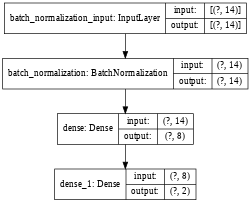

In [31]:
#Vẽ cấu trúc mạng
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48, to_file="SIR_Model_DIAGRAM.png")

In [32]:
#Định nghĩa hàm loss và phương pháp tối ưu
loss_object = tf.keras.losses.MeanSquaredError(reduction='sum')
loss_object_log = tf.keras.losses.MeanSquaredLogarithmicError(reduction='sum')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [33]:
def loss(model, x, y, training=True):
  N0=N_global
  y_pred=model(x, training=training)
  y_pred /=100
  x=x.astype("float32")

  I0, R0= x[0][:2]
  S0=N0-I0-R0
  iteration=x.shape[0]

  S=[S0]
  I=[I0]
  R=[R0]
  for t in range(iteration-1):
    S.append(S[t]- y_pred[t, 0]/N0 * I[t]*S[t])
    I.append(I[t] +y_pred[t, 0]/N0 *I[t] *S[t] - y_pred[t, 1]*I[t])
    R.append(R[t] +y_pred[t, 1]*I[t])
  
  IR_pred=tf.stack([I, R], 1)
  
  max_I =np.array(I).max()
  max_init= y.max()

  #Các thành phần của hàm loss, lấy ý tưởng từ bài báo ở trên
  E_d1= loss_object_log(x[:, :2], IR_pred)
  E_d2= 0.01 * np.log10(max_I)/max_I*loss_object(x[:, :2], IR_pred)
  E_r = 100* np.log10(max_I)/max_init*loss_object(y_pred[:-1], y_pred[1:])
  E_0 = 100* np.log10(max_I)/max_init*loss_object(y, y_pred[0])
  return E_d1+E_d2+E_r +E_0


#Tính đạo hàm dựa theo thư viện TensorFlow
def grads(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value=loss(model, inputs, targets, training=True)
  
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [34]:
#Load data
train_data= load_data()

#Train model
train_loss_results=[]
num_epochs=16001

#L=Khởi tạo các hệ số beta, gamma
init_value=np.array([0.196, 0.037])
train_label= init_value

min_loss= np.inf
min_epochs=[]
early_stop_cnt = 0


for epoch in range(num_epochs):
  if epoch == 2000:
    optimizer.learning_rate.assign(0.005)
  elif epoch == 6000:
    optimizer.learning_rate.assign(0.002)
  elif epoch == 11000:
    optimizer.learning_rate.assign(0.001)

# Use for batch training
  epoch_loss_avg = tf.keras.metrics.Mean()

  loss_value, gradient = grads(model, train_data, train_label)
  optimizer.apply_gradients(zip(gradient, model.trainable_variables))

  epoch_loss_avg.update_state(loss_value)
  train_loss_results.append(epoch_loss_avg.result())

  if epoch_loss_avg.result().numpy() < min_loss:
    min_loss = epoch_loss_avg.result().numpy()
    min_epochs.append(epoch)
    early_stop_cnt = 0
  else:
    early_stop_cnt += 1

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    
print(min_loss)

Epoch 14050: Loss: 3195.305
Epoch 14100: Loss: 3205.136
Epoch 14150: Loss: 3190.721
Epoch 14200: Loss: 3188.745
Epoch 14250: Loss: 3186.785
Epoch 14300: Loss: 3184.615
Epoch 14350: Loss: 3182.773
Epoch 14400: Loss: 3182.727
Epoch 14450: Loss: 3179.041
Epoch 14500: Loss: 3203.073
Epoch 14550: Loss: 3189.489
Epoch 14600: Loss: 3174.013
Epoch 14650: Loss: 3171.574
Epoch 14700: Loss: 3169.412
Epoch 14750: Loss: 3185.721
Epoch 14800: Loss: 3166.051
Epoch 14850: Loss: 3163.808
Epoch 14900: Loss: 4152.561
Epoch 14950: Loss: 3164.806
Epoch 15000: Loss: 3158.524
Epoch 15050: Loss: 3156.743
Epoch 15100: Loss: 5011.215
Epoch 15150: Loss: 3158.800
Epoch 15200: Loss: 3150.953
Epoch 15250: Loss: 3148.762
Epoch 15300: Loss: 4608.375
Epoch 15350: Loss: 3149.933
Epoch 15400: Loss: 3142.756
Epoch 15450: Loss: 3140.899
Epoch 15500: Loss: 3168.685
Epoch 15550: Loss: 3137.144
Epoch 15600: Loss: 3135.209
Epoch 15650: Loss: 3133.032
Epoch 15700: Loss: 3245.851
Epoch 15750: Loss: 3129.525
Epoch 15800: Loss: 3

Text(0.5, 1.0, 'Training loss')

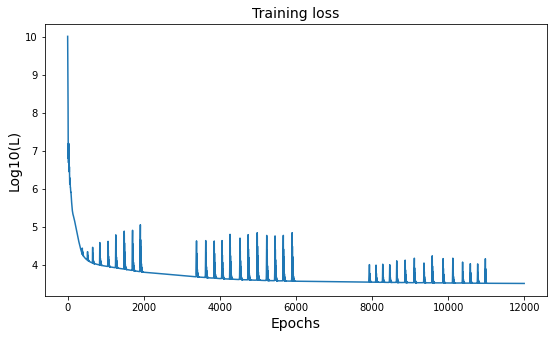

In [35]:
#Vẽ đồ thị hàm loss
if len(train_loss_results) > 12000:
  result = train_loss_results[:12000]
else:
  result = train_loss_results
plt.figure(figsize=(9, 5))

plt.plot(range(len(result)), np.log10(result))
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Log10(L)", fontsize=14)
plt.title("Training loss", fontsize=14)

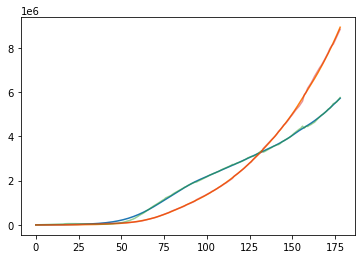

3119.8083


In [36]:
plot_model(model, train_data, min_loss)

In [37]:
# Save trained model
!mkdir -p saved_model

path = "saved_model/model_sir.h5"
model.save(path, save_format="tf")
unreplicated_model = tf.keras.models.load_model(path)

In [38]:
#Load pretrained model
unreplicated_model = tf.keras.models.load_model("saved_model/model_sir.h5")

In [39]:
N0 = N_global
size = train_data.shape[0]

predict = unreplicated_model.predict(train_data) / 100
I0, R0 = train_data[0][:2]
result = SIR_Model(predict[:, 0], predict[:, 1], N0 - I0 - R0, I0, R0, size).T

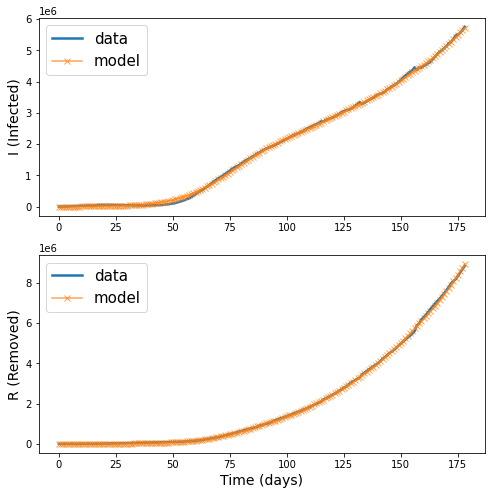

In [40]:
# Vẽ đồ thị so sánh giữa data và model đã train
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(range(size), train_data[:, 0], lw=2.5, label="data")
plt.plot(range(size), result[:, 0], alpha=0.7, marker="x", label="model")
plt.ylabel("I (Infected)", fontsize=14)
plt.legend(fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(range(size), train_data[:, 1], lw=2.5, label="data")
plt.plot(range(size), result[:, 1], alpha=0.7, marker="x", label="model")
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("R (Removed)", fontsize=14)
plt.legend(fontsize=15)

beta:  0.07142335
gamma 0.027194034


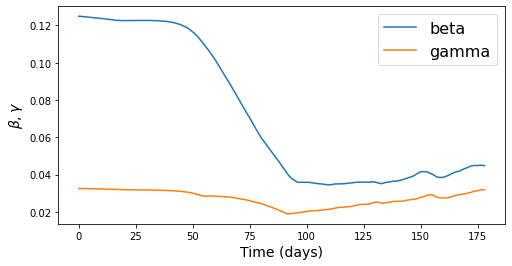

In [41]:
#Vẽ đồ thị beta, gamma
plt.figure(figsize=(8, 4))
beta=predict[:,0].mean()
gamma=predict[:, 1].mean()
print("beta: ", beta)
print("gamma", gamma)
plt.plot(range(size), predict[:, 0], lw=1.5, label="beta")
plt.plot(range(size), predict[:, 1], lw=1.5, label="gamma")
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel(r"$\beta , \gamma$", fontsize=14)
plt.legend(fontsize=16)

In [42]:
#Lưu model dưới dạng zip và tải xuống
!zip -r SIR_MODEL.zip saved_model

from google.colab import files
files.download("SIR_MODEL.zip")


  adding: saved_model/ (stored 0%)
  adding: saved_model/model_sir.h5 (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>